In [1]:
%matplotlib inline


What is `torch.nn` *really*?  (translated by huffon)
============================

- PyTorch는 사용자가 신경망을 모델링하고 훈련시키는데 도움이 될 수 있는 정교히 고안된 모듈과 클래스들을 제공하며, `torch.nn`, `torch.optim`, `Dataset`, `DataLoader` 이 그 좋은 예이다.
- 이러한 모듈들을 잘 활용하고 사용자가 풀고자 하는 문제에 맞게 커스터마이징하기 위해서는 각 모듈들이 내부적으로 어떠한 일을 수행하는지 알 필요가 있다.
- 각 모듈들의 내부 로직을 이해하기 위해 처음에는 아무 모듈도 사용하지 않은 채 기본 신경망을 훈련시켜 볼 것
    - 즉, PyTorch의 가장 기본적인 tensor 기능들만 사용하며 모델링 !
    - 이후, `torch.nn`, `torch.optim`, `Dataset`, `DataLoader` 등의 모듈들을 하나씩 추가해가며 각 모듈이 어떤 역할을 수행하는지 알아볼 것



MNIST 데이터 셋업
----------------

- 가장 기본적인 `MNIST` 데이터셋을 사용할 것: 해당 데이터셋은 손글씨로 적힌 흑백의 0부터 9까지의 숫자로 구성
- Python3의 스탠다드 라이브러리인 `pathlib`을 경로 관리를 위해 사용할 것이며, 데이터셋을 다운로드 할 때는 `requests` 라이브러리를 사용
- 이 때, 라이브러리를 필요한 시기에만 import 함으로써 어떤 라이브러리가 어떤 지점에서 사용되는지를 보다 자세히 확인하게 될 것

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

# parents: 경로에서 필요한 파일이 없을 경우, 생성해주는 옵션
# exist_ok: 이미 경로에 해당하는 폴더가 존재하더라도 괜찮다는 옵션
PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

# 다운로드 받고자 하는 파일이 존재하지 않을 경우, 다운로드 수행
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

- 다운 받은 MNIST 데이터셋은 numpy 배열 포맷으로 구성된 데이터들이 pickle 포맷으로 이진화되어 저장된 형태
- **pickle**은 python에서 데이터의 시리얼라이즈를 위해 사용되는 파일 포맷

In [3]:
import pickle
import gzip

# as_posix: 경로를 string 형태로 반환
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

- 각각의 이미지는 28x28의 픽셀이 1차원으로 나열되어 있는 구조: (28x28) = 784
- 해당 데이터를 2차원으로 reshape 후, 그림으로 찍어보자 !

Total train dataset shape: (50000, 784)


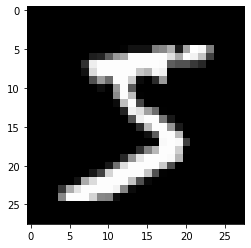

In [4]:
from matplotlib import pyplot
import numpy as np

print(f'Total train dataset shape: {x_train.shape}')
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")

PyTorch는 기본 자료형으로 `torch.tensor`를 사용하기 때문에 데이터를 변환시켜줄 필요가 있음

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape

# torch.tensor로 변환된 데이터와 라벨 확인
print(x_train, y_train)

# 훈련 데이터의 shape 확인
print(x_train.shape)

# 라벨 데이터의 최대, 최소값 확인
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


torch.nn을 사용하지 않고 신경망 구성해보기
---------------------------------------------

- 먼저, PyTorch의 tensor 연산만을 이용해 모델을 구성해보자 !
- PyTorch는 0 혹은 임의의 수로 tensor를 채워줄 수 있는 생성 연산을 제공한다. 
- 우리는 해당 연산을 활용해 차후 선형 모델의 가중치와 편향을 생성할 것 !
- `torch.tensor`는 보통의 tensor와 크게 다르지는 않지만, `기울기` 계산이 필요하다는 정보를 `requires_grad` 속성에 기록한다는 특징을 가진다.
- 해당 속성을 이용해 PyTorch 프레임워크는 tensor에 행해지는 모든 연산을 기록하며, 역전파 수행 시 기울기를 자동으로 계산해주게 되는 것
- 그러니, 기울기 계산을 PyTorch에 맡기기 위해, 가중치 tensor 초기화 이후 `requires_grad` 옵션을 설정해주도록 하자

<div class="alert alert-info"><h4>Note</h4><p>Xavier 가중치 초기화 기법을 이용해 가중치를 초기화 할 것이며, 해당 초기화는 가중치를 1/sqrt(n)만큼 곱해서 이루어짐</p></div>

In [6]:
import math

torch.manual_seed(1234)

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

- PyTorch가 기울기를 자동으로 계산해주는 덕분에, 우리는 Python 표준 함수들을 모델에서도 쉽게 사용할 있게 된다 !
- 또한 **활성화 함수**가 필요하기 때문에 `log_softmax` 함수를 작성할 것.
- PyTorch가 이미 기작성된 손실 함수, 활성화 함수 등을 제공해주기는 하지만, python 함수를 이용해 간단한 사용자 정의 함수를 작성해 사용할 수도 있다는 것을 기억하자.

In [7]:
def log_softmax(x):
    # exp(x)를 row 기준으로 summation 한 뒤, log 취한 값
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

- 위에서 `@` 문자는 dot product 연산을 의미
- 앞서 정의한 함수를 하나의 mini-batch에 대해 호출할 것이며, 한 batch는 64개의 이미지로 구성될 것.
- 가중치가 randn으로 정의되어 있으므로, 초기의 예측값은 좋을 수가 없음 !

In [8]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x: (64, 784)
preds = model(xb)   # predictions: (64, 10)
print(preds[0], preds.shape)

tensor([-3.0721, -2.1118, -2.0323, -2.4976, -2.3852, -2.3374, -2.0391, -2.3284,
        -2.1738, -2.4151], grad_fn=<SelectBackward>) torch.Size([64, 10])


- 앞서 확인했듯 `preds` tensor는 값 뿐만 아니라, gradient 함수 정보를 포함며 해당 정보는 이후 역전파에 사용
- 이제 손실 함수로 사용할 `Negative log-likelihood` 함수를 정의해보자 !

In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()   # [row, column]

loss_func = nll

임의로 정의된 가중치를 사용한 모델의 손실 값을 확인한 후, 역전파를 거친 후의 성능이 개선되는지 살펴볼 것

In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3525, grad_fn=<NegBackward>)


- 이번엔 모델의 정확도를 계산할 함수를 정의해보자
- prediction에서 가장 높은 확률 값을 가진 원소의 인덱스와 타겟 값이 같을 경우 예측이 성공한 것으로 상정

In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

임의로 정의된 가중치를 사용한 모델의 정확도를 확인한 후, 손실 값이 줄어듬에 따라 성능이 개선되는지 살펴보자

In [12]:
print(accuracy(preds, yb))

tensor(0.1094)


이제 반복문을 이용해 훈련을 진행해보자:

- 미니배치 사이즈를 설정(`bs`)
- 모델을 이용해 예측 값 계산
- 손실 함수를 이용해 손실 값 계산
- `loss.backward()` 함수를 이용해 모델의 `가중치`와 `편향`의 기울기를 업데이트

기울기 업데이트는 `torch.no_grad()` 컨텍스트에서 이루어져야 하는데, 기울기를 업데이트하는 과정에서 발생하는 연산들이 다음 번 기울기 계산 과정에 포함되지 않게 하기 위함

이후, 다음 반복을 수행하기 위해 기울기들을 0으로 초기화

기울기의 0 초기화를 수행해주지 않으면 `loss.backward()` 과정에서 발생하는 기울기들이 모두 쌓이게 되고 이는 가중치 업데이트를 저해

In [13]:
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

지금까지 가장 간소화 된 신경망 네트워크를 생성하고 훈련해보았음

이제 훈련 이후의 손실 값과 정확도를 확인해보자 !

우리는 손실 값은 줄어들고 정확도는 올라가기를 기대했으며, 실제로 그렇게 학습이 되었음

In [14]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0823, grad_fn=<NegBackward>) tensor(1.)


torch.nn.functional 사용하기
------------------------------

- 이제 앞서 정의한 함수들과 동일한 기능을 PyTorch의 `nn` 클래스들이 수행하도록 리팩토링 할 것
- PyTorch의 클래스들을 이용하면 우리는 보다 짧고, 이해하기 쉽고, 확장이 용이한 코드를 작성할 수 있음


- 앞서 작성한 코드들을 단축시키는 가장 쉬운 방법은 손수 작성한 활성화 함수와 손실 함수를 `torch.nn.functional`로 대체하는 것 !
- 해당 모듈은 `torch.nn`에 속한 함수들을 모두 포함하며, 다양한 활성화 함수와 신경망을 생성할 때 도움이 될 수 있는 pooling 함수 등을 내포
    - 해당 모듈은 convolution 연산을 수행하는 함수, 선형 계층 등도 포함하고 있지만 해당 기능들은 다른 모듈을 이용하는 것이 편리함
- `negative log likelihood` 손실 값과 `log softmax` 함수를 사용한다면, PyTorch는 이 둘을 결합한 하나의 함수 `F.cross_entropy`를 제공
    - 따라서 손실 함수의 대체를 통해 활성화 함수까지 기존 모델에서 지울 수 있게 됨 !

In [15]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

`model` 함수에서 더 이상 `log_softmax`를 호출하지 않음에 주목하자

그리고 이전과 같이 손실 값과 정확도를 출력해보도록 하자

**이전 모델**

```
def model(xb):
    return log_softmax(xb @ weights + bias)
```

In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0823, grad_fn=<NllLossBackward>) tensor(1.)


nn.Module 사용하기
-----------------------------
- 이제 `nn.Module`과 `nn.Parameter`를 사용해 보다 깔끔하고 **정확한** 훈련 과정을 거쳐보도록 하자.
- 우선 `nn.Module`을 상속 받는 모델을 정의하도록 한다. (`nn.Module`은 자체로 하나의 클래스이며, 클래스 내의 상태 변화를 추적 가능)
- 또한 클래스가 가중치와 편향 등의 학습 파라미터를 관리하게 하고, 순전파를 위한 `forward` 함수를 정의할 수 있음
- `nn.Module`은 다양한 속성과 함수를 자체적으로 포함하고 있으며, 우리는 이중 `.parameters()`와 `.zero_grad()` 함수를 사용할 것 !

In [17]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

지금부터 함수가 아닌 **객체**를 모델로 이용하기 때문에, 사용 시 모델 객체를 초기화 해주어야 함

In [18]:
model = Mnist_Logistic()

- 손실 값은 이전과 같은 코드로 계산할 수 있음
- 우리는 `nn.Module` 객체를 함수와 같이 사용할 수 있으며, 내부적으로 PyTorch 프레임워크는 모델의 `forward` 함수를 자동으로 호출
    - 즉, `nn.Module` 객체는 *callable* 한 객체라고 볼 수 있음

In [19]:
print(loss_func(model(xb), yb))

tensor(2.2792, grad_fn=<NllLossBackward>)


이전에 우리는 훈련을 수행하는 **반복문 내에서** 파라미터들을 변수명에 각각 업데이트 해주었으며, 매 배치마다 발생한 기울기를 손수 초기화해주었음

```
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```

이제는 `model.parameters()`와 `model.zero_grad()` 메소드를 이용해 해당 과정을 보다 간결하고 손쉽게 수행 

이는 이후 보다 복잡한 모델을 사용할 때, 사용자가 모든 파라미터 변수명을 손수 관리하고 기억하지 않을 수 있도록 도와줌

```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

이제 모델의 훈련 과정을 `fit` 함수로 감싸도록 하자

In [20]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

해당 훈련을 통해 손실 값이 내려갔는지 확인해보자

In [21]:
print(loss_func(model(xb), yb))

tensor(0.0825, grad_fn=<NllLossBackward>)


nn.Linear 사용하기
-------------------------

- `self.weights`와 `self.bias` 등 파라미터를 손수 정의, 초기화 및 계산하는 대신 선형 연산을 담당하는 `nn.Linear` 계층을 사용하자 !
- PyTorch는 다양한 기정의된 계층들이 있으며, 해당 계층들을 이용해 우리는 모델 코드를 엄청나게 간소화 시킬 수 있음

In [22]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        # Linear 계층은 He Uniform initialization 사용 !
        # bias는 기본 값이 True로 설정되어 있기 때문에 자동으로 생성됨
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

정의한 모델의 객체를 생성하고, 손실 값을 이전과 같이 계산해준다.

In [23]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3033, grad_fn=<NllLossBackward>)


모델 부의 수정만 있었으므로 앞서 정의한 `fit` 함수를 그대로 사용하도록 하자 !

In [24]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0823, grad_fn=<NllLossBackward>)


optim 사용하기
------------------------------

- PyTorch는 다양한 최적화 알고리즘을 `torch.optim` 라이브러리를 통해 제공한다.
- `torch.optim`을 이용한다면 파라미터들을 손수 업데이트하지 않고 `step` 함수를 이용해 최적화 알고리즘이 직접 minima를 찾아가도록 할 수 있다.

optim의 사용은 앞서 정의한 훈련 과정에서 파라미터를 **손수 업데이트** 하는 부분을 대체할 수 있다:
```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

이제 위의 코드 대신 아래와 같은 간결한 코드를 사용할 수 있게 된다:

```
opt.step()
opt.zero_grad()
```

(`optim.zero_grad()`는 기울기 값들을 0으로 초기화해주며, 해당 함수는 반드시 다음 미니배치의 훈련 이전에 호출되어야 함)

In [25]:
from torch import optim

모델과 최적화 알고리즘을 재사용할 수 있도록 간단한 함수 `get_model`을 정의하자.

In [26]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2386, grad_fn=<NllLossBackward>)
tensor(0.0819, grad_fn=<NllLossBackward>)


Dataset 사용하기
------------------------------

- PyTorch는 데이터셋을 PyTorch 환경에서 요긴하게 사용할 수 있도록 도와주는 Dataset이라는 추상 클래스를 지님
- Dataset은 파이썬 메소드 `len`을 사용하기 위한 `__len__`과 자신이 지니고 있는 원소들의 인덱스를 메기기 위한 `__getitem__` 함수를 지니는 것이면 무엇이든 될 수 있음
- Dataset의 자세한 활용은 [튜토리얼](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)을 참조할 것 !


- PyTorch의 `TensorDataset`은 tensor들을 감싸는 데이터셋
- 길이와 인덱싱 방법을 정의해주면 `TensorDataset`은 iterate, index 그리고 slice를 기능을 1차원의 tensor와 함께 제공해줌

In [27]:
from torch.utils.data import TensorDataset

이제 `x_train`와 `y_train`을 `TensorDataset`이라는 하나의 객체로 묶을 수 있음

In [28]:
train_ds = TensorDataset(x_train, y_train)

이전에 우리는 데이터와 라벨 값의 미니배치를 각각 iterate 해야 했음:
```
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]
```

이제는 두 과정을 한 번에 수행 가능:
```
xb,yb = train_ds[i*bs : i*bs+bs]
```

In [29]:
model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2774, grad_fn=<NllLossBackward>)
tensor(0.0796, grad_fn=<NllLossBackward>)


DataLoader 사용하기
------------------------------

- PyTorch의 `DataLoader` 클래스는 Dataset의 전체 배치를 관리하는 역할을 수행
- `__len__`과 `__getitem__` 메소드를 가지는 어떤 `Dataset` 클래스도 `DataLoader` 클래스의 인자가 될 수 있음 !


- `DataLoader`는 배치 사이즈로 나뉘어진 미니 배치들을 iterate 하기 쉽게 도와주는 기능 제공

In [30]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs) # iterable object
print(f'Total: {len(x_train)}, batch size: {bs}, total mini-batches: {len(train_dl)}')

Total: 50000, batch size: 64, total mini-batches: 782


이전에 우리가 미니배치를 위해 사용한 반복문은 다음과 같음:
```
n, c = x_train.shape

for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
```

이제 DataLoader를 이용함에 따라 미니배치가 배치 사이즈에 맞게 자동으로 할당되고, 반복문을 다음과 같이 더 간결하게 작성할 수 있음:
```
for xb,yb in train_dl:
    pred = model(xb)
```

In [31]:
model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2785, grad_fn=<NllLossBackward>)
tensor(0.0806, grad_fn=<NllLossBackward>)


PyTorch가 제공하는 `nn.Module`, `nn.Parameter`, `Dataset` 그리고 `DataLoader` 덕분에 훈련 반복문을 보다 간결하고 이해하기 쉽게 작성할 수 있게 되었음

이제 모델을 실용적이고, 효율적으로 생성하기 위해 필요한 기본 기능들을 더 추가해보도록 하자 !

validation 과정 추가
-----------------------

- Section 1에서 우리는 단순히 그럴싸한 훈련 과정을 정의하는데에만 집중했음
- 그러나, 실제 실험에서는 **항상** 모델이 과적합 되지 않는지를 확인하기 위한 `검증 데이터셋`을 지녀야 함


- 훈련 데이터를 잘 섞어주는 것은 미니 배치들과 과적합의 상관성을 예방하기 위해 매우 중요한 과정
- 훈련 데이터를 섞어주지 않으면 검증 데이터 셋을 섞든, 섞지 않든 항상 같은 검증 손실 값을 발생시킬 것임
    - But, 검증 데이터 셋에 대해서는 shuffling을 수행해줄 필요가 전혀 없음


- 검증 데이터 셋에 대해서는 훈련 데이터 셋의 배치 사이즈에 2배에 달하는 미니 배치를 생성할 것임
- 왜냐하면 검증 과정에서는 역전파 과정이 불필요하고 이에 따라 사용되는 메모리가 더 적기 때문 ! (기울기 저장 X)
- 이를 활용해 더 큰 크기의 미니 배치를 할당하고, 손실 값을 보다 빨리 계산하도록 함

In [32]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

우리는 매 epoch의 학습 이후, 검증 손실 값을 계산하고 출력하도록 할 것임

(훈련 이전에는 `model.train()` 함수를 호출해주고, 추론 이전에는 `model.eval()` 함수를 실행시켜주는 것을 잊지 말도록 하자. 이는 `nn.BatchNorm2d`이나 `nn.Dropout`과 같은 계층들이 상황에 맞게 on/off와 같이 적절한 행동을 취하게 하기 위함 !)

In [33]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(f'Epoch: {epoch}, Loss: {(valid_loss / len(valid_dl)).item()}')

Epoch: 0, Loss: 0.2952827215194702
Epoch: 1, Loss: 0.2895992398262024


fit() 함수와 get_data() 함수 생성
----------------------------------

- 이제 다시 조금의 리팩토링을 수행해보도록 하자.
- 지금까지 훈련 데이터셋과 검증 데이터셋에서 손실 값을 계산하는 과정을 두 번 거치고 있었다. 
- 이를 개선하기 위해 `loss_batch`라는 함수를 정의해보도록 하자.


훈련 데이터 셋을 이용해 손실 값을 계산할 때는 최적화 알고리즘 (optimizer) 인자로 넘겨 역전파를 수행하도록 한다.

검증 데이터셋의 손실 값을 계산할 때는 역전파를 수행하지 않기 때문에 optimizer를 인자로 넘겨주지 않는다.

In [34]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

`fit` 함수는 모델을 훈련하기 위해 필요한 필수 연산들을 수행하며, 매 epoch 마다 훈련, 검증 손실 값을 계산한다.

In [35]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        # 검증 데이터셋에 대해 손실 값을 구할 때는 전체 검증 데이터셋의 평균 손실 값을 구하도록 한다.
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

`get_data` 함수는 훈련 데이터셋과 검증 데이터셋을 배치로 할당한 DataLoader를 반환

In [36]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

이제 DataLoader를 생성하고, 모델을 실행시키기까지 단 3줄의 코드만이 사용됨

In [37]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.2984700796127319
1 0.30469343619346617


CNN은 어떻게 구성할 수 있을까?
-------------

- 우리는 이제 3개의 convolutional 계층을 가진 신경망을 설계해 볼 것
- 이전에 작성한 함수들은 모두 특정 모델을 상정하고 정의된 것이 아니기 때문에 CNN 모델을 설계할 때도 해당 함수들을 그대로 사용할 수 있음


- 이번 설계에서는 기정의된 `nn.Conv2d` 계층을 convolutional 계층으로 사용할 것
- 각각의 convolution 계층은 ReLU 함수를 활성화 함수로 사용
- 이후, ReLU를 거친 값들에 Average pooling을 적용 (PyTorch의 `view`는 numpy에서의 `reshape`로 생각할 수 있음 !)

In [38]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        # xb : [64, 784]
        xb = xb.view(-1, 1, 28, 28)      # xb -> [64, 1, 28, 28]
        xb = F.relu(self.conv1(xb))      # xb -> [64, 16, 14, 14]
        xb = F.relu(self.conv2(xb))      # xb -> [64, 16, 7, 7]
        xb = F.relu(self.conv3(xb))      # xb -> [64, 10, 4, 4]
        xb = F.avg_pool2d(xb, 4)         # xb -> [64, 10, 1, 1]
        return xb.view(-1, xb.size(1))  # xb -> [64, 10]

lr = 0.1

[Momentum](https://cs231n.github.io/neural-networks-3/#sgd) 업데이트는 SGD의 변형으로 이전의 기울기 업데이트를 고려해 보다 빠른 훈련이 가능케 해준다.

In [39]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34340459880828855
1 0.21969150352478028


nn.Sequential
------------------------

- `torch.nn`은 손쉽게 커스터마이징이 가능한 클래스 `Sequential`을 제공하기도 한다.
- `Sequential` 객체는 자신이 포함하고 있는 모듈들을 순서대로 실행시켜주는 역할을 담당한다.


- `Sequential`의 장점을 극대화하기 위해 **커스텀 레이어**를 작성해보자.
- 예를 들어, PyTorch는 `view`를 수행하기 위한 계층이 따로 존재하지 않는다.
- `view` 함수를 수행하는 `Lambda` 계층을 커스텀 레이어로 작성해 `Sequential`에 추가해보도록 하자 !

In [40]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

`Sequential`을 이용한 모델은 다음과 같이 간단하게 만들 수 있다.

In [41]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    # 다른 reshape을 수행하는 view 함수를 lambda function 인자로 넘겨줄 수도 있음
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.45787983198165894
1 0.2781207921028137


GPU 사용하기
---------------

만약 CUDA 사용이 가능한 GPU를 가지고 있다면, 훈련 속도를 굉장히 증진시킬 수 있다 !

먼저 CUDA 사용이 가능한지 확인하기 위해 다음과 같은 코드를 실행시켜보자

In [42]:
print(torch.cuda.is_available())

False


이제 cuda 옵션을 포함하는 device 객체를 생성하자.

In [43]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [44]:
print(dev)

cpu


`preprocess` 함수를 수정해 batch들을 GPU로 옮겨주도록 하자

In [45]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

마지막으로 우리의 모델도 GPU로 옮겨주도록 하자

In [46]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

이제 보다 빠른 훈련 속도를 경험할 수 있게 될 것이다 !

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

마무리하며..
-----------------

이제 우리는 PyTorch를 이용해 다양한 모델을 훈련할 수 있는 파이프 라인을 정의할 수 있게 되었다 !

지금까지 학습한 내용을 요약해보도록 하자:

- **torch.nn**
    - `Module`: 함수와 같이 호출이 가능하며, 신경망 계층들의 가중치 변화들을 관리할 수 있는 편리한 객체. Module 객체는 어떠한 `Parameter`들을 포함하고 있는지를 기록하며, 기울기의 0 초기화, 가중치 업데이트들을 수행할 수 있도록 편리한 함수를 제공하기도 한다 !
    - `Parameter`: `Module` 객체에게 가중치의 존재와 역전파를 통해 가중치 업데이트가 필요하다고 알리는 텐서의 Wrapper 클래스. `Parameter`내의 `requires_grad` 속성을 가지고 있는 텐서들만 가중치 업데이트를 받을 수 있음
    - `functional`: 활성화 함수, 손실 함수 등을 포함하고 있는 모듈. 합성곱 계층, 선형 계층 등도 포함하지만 앞서 언급한 것과 같이 이들은 nn.Linear와 같이 해당 연산을 전문적으로 수행하는 계층으로 사용하는 것이 바람직


- **torch.optim**: `SGD`와 같이 역전파 과정 중 `Parameter`의 가중치를 업데이트 하는 최적화 알고리즘들을 포함


- **Dataset**: 길이를 나타내는 `__len__`과 인덱싱을 통해 데이터 추출이 가능한 `__getitem__` 함수를 포함해 tensor들을 관리하는 `TensorDataset`과 같이 편리한 클래스들을 제공해주는 추상 인터페이스 객체


- **DataLoader**: `Dataset`을 받아 데이터를 반복문에서 사용할 수 있는 mini-batch iterator들로 변환해주는 객체